In [1]:
!pip install matplotlib #==3.3.0
!pip install nibabel #==3.2
!pip install nilearn
!pip install simpleitk
!pip install SimpleITK-SimpleElastix 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 28.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.1 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import cv2
import pandas as pd
import scipy.ndimage as ndi
import seaborn as sns
import SimpleITK as sitk
import sys
import os
import scipy

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/Final-Year-Project')

Mounted at /content/drive


# Loading and Formatting the Data:
- loads the nifti files for each of the patients original and follow-up scans (Maper follow-up is not provided by ADNI)

- stores the patient ID in the header of the image (if not already there) to ensure there is clarity to whom each scan belongs at all points beyond variable names

In [5]:
import os

def load_folder_nibabel(dir_name): 
  directory = dir_name
  scans = [] #stores all scans of a certain segmentation tool and point in time in an iterable list for later processing
  
  # iterate over each files in the directory
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      patient_id = filename[:10] #each scan is stored so that the patient id comes first

      # checking if it is a file
      if os.path.isfile(f):      
          scan = nib.load(f)
          scan.header['db_name'] = patient_id #in order to make sure that the scans are clearly identifiable later -> for those scan that don't have it already (like MONAI and FS) the db_name is that of the patient id which can be indexed later to compare scans of the same patient
          scans.append(scan)
          

  return scans

In [6]:
# using the function to load in the pre-processed segementation data using nibabel:

FS_original_scans = load_folder_nibabel('FS_Segmentations')
MONAI_original_scans = load_folder_nibabel('MONAI_Segmentations') 
SNT_original_scans = load_folder_nibabel('SNT_Segmentations') 
MAPER_original_scans = load_folder_nibabel('MAPER_Segmentations') 

FS_follow_up_scans = load_folder_nibabel('FS_Follow_New')
MONAI_follow_up_scans = load_folder_nibabel('MONAI_Follow_Up') 
SNT_follow_up_scans = load_folder_nibabel('SNT_Follow_Up') 

In [7]:
FS_original_extra_scans = load_folder_nibabel('FS_Extra_Original')
MAPER_original_extra_scans = load_folder_nibabel('MAPER_Extra_Original')
SNT_original_extra_scans = load_folder_nibabel('SNT_Extra_Original')

In [8]:
# creating a dictionary to link each list of scan and according hippocampal segmentation numbers with its segmentation tool 
data_original_dict = {'FreeSurfer' : (FS_original_scans, [17, 53]), 
                      'MONAI' : (MONAI_original_scans, [17, 16]), 
                      'SNT': (SNT_original_scans,[21, 20]), 
                      'MAPER': (MAPER_original_scans, [512, 256]),
                  }

In [9]:
data_all_original_dict = {'FreeSurfer' : (FS_original_scans + FS_original_extra_scans, [17, 53]), 
                          'SNT': (SNT_original_scans + SNT_original_extra_scans, [21, 20]), 
                          'MAPER': (MAPER_original_scans + MAPER_original_extra_scans, [512, 256]),
                         }

In [10]:
# creating a dictionary to link each list of scan and according hippocampal segmentation numbers with its segmentation tool 
# Note: MAPER segmentation was not available through ADNI for the follow-up scans of the patients

data_follow_up_dict = {'FreeSurfer' : (FS_follow_up_scans, [17, 53]), 
                      'MONAI' : (MONAI_follow_up_scans, [17, 16]), 
                      'SNT': (SNT_follow_up_scans,[21, 20]), 
                      }

In [11]:
print(FS_original_scans[1].header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'002_S_0413'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 0.70710677
quatern_d       : -0.70710677
qoffset_x       : 125.311844
qoffset_y       : -93.39498
qoffset_z       : 115.43281
sro

/usr/local/lib/python3.9/dist-packages/nilearn/plotting/find_cuts.py:143: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(


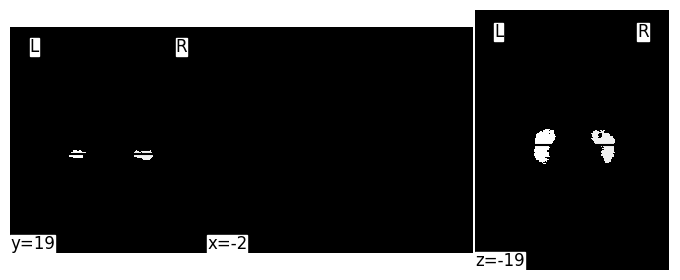

In [12]:
plotting.plot_img(MONAI_original_scans[1], cmap = 'gray')

## Plotting Pixel Intensity Histogram to Idenity Peaks:

In [13]:
test_img = SNT_original_scans[0].get_fdata()

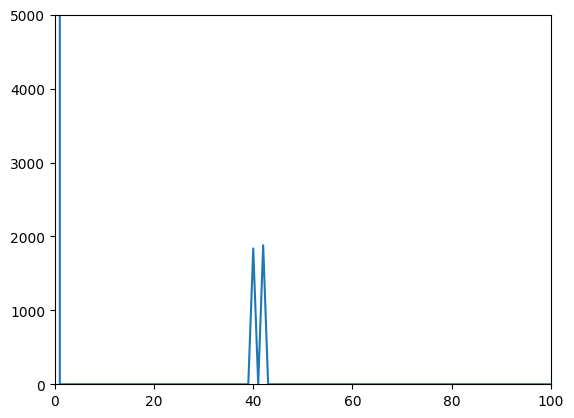

In [14]:
ax1 = plt.subplot(111)
hist = ndi.histogram(test_img ,min=0,max=500,bins=1000) #need to change the scale of the histogram? as 1e^7? doesn't show the 
plt.plot(hist)
ax1.set_ylim([0, 5000])
ax1.set_xlim([0, 100])
plt.show()

In [15]:
np.unique(test_img) #getting the unique pixel intensities from the MRI image data where each number (besides the 0 - background) corresponds to one side of the hippocampus segment

array([ 0., 20., 21.])

In [16]:
# the order of the scan list is : scans_list = [scans_monai, scans_fs, scans_snt, scans_maper] and segments are order left then right
# Note: for the SNT the segmentation numbers to index the left and right hippocampus tend to vary for some scans so will be found inidividually for each scan -> thus simply put 0,0 for now
segment_nums_list = [[17, 16], [17, 53], [0, 0], [512, 256]]

# Computing Segmentation Volume:

In [17]:
def compute_voxel_size(scan):

  #Computing one voxels dimensions of the scan:
  pixel_dims = (scan.header["pixdim"][1:4]) #The value in float pixdim[0] is the qfac value and should always be -1 or 1.
  voxel_dims = pixel_dims[0] * pixel_dims[1] * pixel_dims[2]

  return voxel_dims

In [18]:
def compute_non_zero_volume(scan):
  
  #Counting up the non-zero voxels:
  num_vox_volume = np.sum(scan.get_fdata() > 0)


  #compute the given scan's voxel dimensions:
  voxel_dims = compute_voxel_size(scan)

  # Calculating Mask Volume:
  non_zero_volume = num_vox_volume * voxel_dims

  return non_zero_volume

In [19]:
def compute_segmentation_volume(scan, seg_num):
  
  #Counting up the non-zero voxels:
  num_vox_seg = np.sum(scan.get_fdata() == seg_num)

  #compute the given scan's voxel dimensions:
  voxel_dims = compute_voxel_size(scan)

  # Calculating Mask Volume:
  segmentation_volume = num_vox_seg * voxel_dims

  return segmentation_volume

In [20]:
def compute_hippocampi_segmentations(scan, seg_nums): #this function intakes both the left and right segmentation number to compute the individual hippocampal segmentation volume in mm^3

  #Counting up the voxels at the specified pixel intensity:
  seg_vol_hippo_left = compute_segmentation_volume(scan, seg_nums[0]) #the segment number for the left hippocampus stored at index 0
  seg_vol_hippo_right = compute_segmentation_volume(scan, seg_nums[1]) #the segment number for the right hippocampus stored at index 1

  return seg_vol_hippo_left, seg_vol_hippo_right

In [21]:
print(compute_hippocampi_segmentations(MONAI_original_scans[1], [17, 16]))

(2979.0, 3114.0)


In [22]:
# in order to get the patient ids corresponding to each scan use the header information -> to create dataframe 
def get_patient_ids(scans):
  patient_ids = []

  for i in range(len(scans)):
    id = str(scans[i].header["db_name"])
    patient_ids.append(id[2:-1]) #the id is stored between b' ' which is not needed


  return patient_ids   

In [23]:
# create a dict which holds a patient's id with the corresponding scan of a tool so that it can be ordered easily later
def dict_patient_id_scan(list_scans_tool):
  patient_ids = get_patient_ids(list_scans_tool)
  dict_patient_id_scan = {}

  for i in range(len(list_scans_tool)):
    dict_patient_id_scan[patient_ids[i]] = list_scans_tool[i]

  return dict_patient_id_scan

In [24]:
# there has been a human-error im the SNT (semi-manual) labelling where for the scans of patient '002_S_0413' other segementation pixel intensity numbers for the hippocampus were used 
# through experimentation I have found the right hippocampal pixel intensity which can be used to find both right and left as the SNT only contains the hippocampal mask

def impute_missing_value(scan, seg_nums):
  hippocampal_vol = compute_non_zero_volume(scan)
  seg_vol_hippo_left, unknown = compute_hippocampi_segmentations(scan, seg_nums)
  seg_vol_hippo_right = hippocampal_vol - seg_vol_hippo_left

  return seg_vol_hippo_left, seg_vol_hippo_right

In [25]:
def compute_dict_volumes(scans_dict, separate=True):

  volume_data_dicts = [] # for each type of tool used to get the segmentations a new list of volumes for the patients is started to be shown in the columes of the dataframe 
  tools_list = []

  #computing the volume for each patient's segmented scan for each list of scan generated by a given segmentation tool
  for tool in scans_dict:
    i = 0 
    hippo_vol_pairs_dict = {}
    tools_list.append(tool) 
     

    scans_list = scans_dict[tool][0] #indexing into the scans list produced with a given tool (which is the dicts key)
    seg_nums = scans_dict[tool][1] #indexing into the corresponding segmentation numbers for the hippocampus of a given tool
    patient_ids = get_patient_ids(scans_list) #getting the unqiue patient id order of scans of the list

    for scan in scans_list:

      #accounting for the outlier cases of the semi-manual scan segmentation (SNT) which for some scans use different segment number for the hippocampi -> thus finding these indiviudally for each scan
      if tool == 'SNT':
        pix_nums = np.unique(scan.get_fdata()) #the intensity at index 0 will always be 0 which corresponds to the black background 
        right_seg_num = pix_nums[1]
        left_seg_num = pix_nums[2]
        seg_vol_hippo_left, seg_vol_hippo_right = compute_hippocampi_segmentations(scan, [left_seg_num, right_seg_num]) #computing the left and right hippocampal volume

        if separate==False: #check if the combined hippocampal volume (left and right) or separate one is one is wanted
          combined_seg_vol_hippo = np.sum([seg_vol_hippo_left, seg_vol_hippo_right]) #add the two volumes to get the full hippocampal volume of the patient
          hippo_vol_pairs_dict[patient_ids[i]] = np.round(combined_seg_vol_hippo,2)

        else:
          hippo_vol_pairs_dict[patient_ids[i] + ' - Left'] = np.round(seg_vol_hippo_left,2)
          hippo_vol_pairs_dict[patient_ids[i] + ' - Right'] = np.round(seg_vol_hippo_right,2)

      
      # for the other tools e.g. FS and MAPER the segmentation numbers for the hippocampi are awlays uniform and stored in the input list seg_nums
      else:
        seg_vol_hippo_left, seg_vol_hippo_right = compute_hippocampi_segmentations(scan, seg_nums) #computing the left and right hippocampal volume

        if separate==False: #check if the combined hippocampal volume (left and right) or separate one is one is wanted
          combined_seg_vol_hippo = np.sum([seg_vol_hippo_left, seg_vol_hippo_right]) #add the two volumes to get the full hippocampal volume of the patient
          hippo_vol_pairs_dict[patient_ids[i]] = np.round(combined_seg_vol_hippo,2)

        else:  
          hippo_vol_pairs_dict[patient_ids[i] + ' - Left'] = np.round(seg_vol_hippo_left,2)
          hippo_vol_pairs_dict[patient_ids[i] + ' - Right'] = np.round(seg_vol_hippo_right,2)



      i = i+1

    volume_data_dicts.append(hippo_vol_pairs_dict) #storing each of the segmentation tools' dictionaries which holds the left and right hippocampal volume of each patient  

  return  volume_data_dicts,  tools_list

In [26]:
# testing the function -> holds a list of individual volume dicts one for each segmentation tool 
# -> dict was chosen to be able to create a dataframe indexing into the patient ids to create columes

volumes_original_dicts_list,  tools_list_original = compute_dict_volumes(data_original_dict)
combined_volumes_original_dicts_list,  tools_list_original = compute_dict_volumes(data_original_dict, separate=False)

print(tools_list_original)
print(combined_volumes_original_dicts_list[0])
print(volumes_original_dicts_list[0])
print(len(volumes_original_dicts_list))

['FreeSurfer', 'MONAI', 'SNT', 'MAPER']
{'002_S_0295': 7346.0, '002_S_0413': 7140.0, '027_S_0256': 5584.0, '033_S_0723': 6655.0, '002_S_0938': 4453.0, '002_S_1018': 7396.0}
{'002_S_0295 - Left': 3536.0, '002_S_0295 - Right': 3810.0, '002_S_0413 - Left': 3545.0, '002_S_0413 - Right': 3595.0, '027_S_0256 - Left': 2818.0, '027_S_0256 - Right': 2766.0, '033_S_0723 - Left': 3271.0, '033_S_0723 - Right': 3384.0, '002_S_0938 - Left': 2323.0, '002_S_0938 - Right': 2130.0, '002_S_1018 - Left': 3798.0, '002_S_1018 - Right': 3598.0}
4


In [27]:
volumes_follow_up_dicts_list,  tools_list_follow_up = compute_dict_volumes(data_follow_up_dict)
combined_volumes_follow_up_dicts_list,  tools_list_follow_up = compute_dict_volumes(data_follow_up_dict, separate=False)

print(tools_list_follow_up)
print(combined_volumes_follow_up_dicts_list[0])
print(volumes_follow_up_dicts_list[0])
print(len(volumes_follow_up_dicts_list))

['FreeSurfer', 'MONAI', 'SNT']
{'002_S_0295': 7181.0, '002_S_0413': 7093.0, '002_S_0938': 4107.0, '002_S_1018': 7350.0, '027_S_0256': 5299.0, '033_S_0723': 6741.0}
{'002_S_0295 - Left': 3514.0, '002_S_0295 - Right': 3667.0, '002_S_0413 - Left': 3505.0, '002_S_0413 - Right': 3588.0, '002_S_0938 - Left': 2161.0, '002_S_0938 - Right': 1946.0, '002_S_1018 - Left': 3779.0, '002_S_1018 - Right': 3571.0, '027_S_0256 - Left': 2759.0, '027_S_0256 - Right': 2540.0, '033_S_0723 - Left': 3331.0, '033_S_0723 - Right': 3410.0}
3


# Displaying Hippocampal Volumes:

In [28]:
def df_hippo_vol(scans, seg_nums, tool):

  hippo_vol_pairs = []
  patient_ids = get_patient_ids(scans)

  #computing the volume for each patient's segmented scan - left and right
  for scan in scans:
    seg_vol_hippo_left, seg_vol_hippo_right = compute_hippocampi_segmentations(scan, seg_nums)
    hippo_vol_pairs.append((seg_vol_hippo_left, seg_vol_hippo_right))


  #format the data and create data frame with the values
  data_hippo_vol_pairs = {'Patient_IDs': patient_ids, tool: hippo_vol_pairs}
  df_hippo_vol_pairs = pd.DataFrame(data=data_hippo_vol_pairs)
  df_hippo_vol_pairs = df_hippo_vol_pairs.T
  df_hippo_vol_pairs = df_hippo_vol_pairs.style.set_caption("Left and Right Hippocampal Volumes in mm^3")

  return df_hippo_vol_pairs

In [30]:
def df_hippo_vol_dict(scans_dict, cols, separate=True):

  volume_data_dicts,  tools_list = compute_dict_volumes(scans_dict, separate)

  #format the data and create data frame with the values
  df_hippo_vol_dict = pd.DataFrame(data=volume_data_dicts)
  df_hippo_vol_dict.index = tools_list

  df_hippo_vol_dict = df_hippo_vol_dict[cols]

  return df_hippo_vol_dict


In [31]:
#formatting the order of patient ids to make it comparable for the original and follow-up scan datafram 
cols_indiv_vol_patients = ['002_S_0295 - Left', '002_S_0295 - Right', '002_S_0413 - Left', '002_S_0413 - Right',    ##these patients are classified as CN
                       '027_S_0256 - Left', '027_S_0256 - Right', '033_S_0723 - Left', '033_S_0723 - Right',   ##these patients are classified as MCI
                       '002_S_0938 - Left', '002_S_0938 - Right', '002_S_1018 - Left', '002_S_1018 - Right']  ##these patients are classified as AD

cols_combined_vol_patients = ['002_S_0295', '002_S_0413',    ##these patients are classified as CN
                       '027_S_0256', '033_S_0723',    ##these patients are classified as MCI
                       '002_S_0938', '002_S_1018']    ##these patients are classified as AD

In [32]:
df_combined_original_data = df_hippo_vol_dict(data_original_dict, cols_combined_vol_patients, separate=False)
display(df_combined_original_data)

,002_S_0295,002_S_0413,027_S_0256,033_S_0723,002_S_0938,002_S_1018
FreeSurfer,7346.00,7140.00,5584.00,6655.00,4453.00,7396.00
MONAI,6093.00,5740.00,4618.00,5467.00,4512.00,5947.00
SNT,3999.29,4260.77,3034.31,3692.45,2578.72,3710.08
MAPER,4494.09,4657.79,3616.50,3548.96,3708.45,4270.74


In [33]:
df_original_data = df_hippo_vol_dict(data_original_dict, cols_indiv_vol_patients)
display(df_original_data)

,002_S_0295 - Left,002_S_0295 - Right,002_S_0413 - Left,002_S_0413 - Right,027_S_0256 - Left,027_S_0256 - Right,033_S_0723 - Left,033_S_0723 - Right,002_S_0938 - Left,002_S_0938 - Right,002_S_1018 - Left,002_S_1018 - Right
FreeSurfer,3536.00,3810.00,3545.00,3595.00,2818.00,2766.00,3271.00,3384.00,2323.00,2130.00,3798.00,3598.00
MONAI,2979.00,3114.00,2610.00,3130.00,2140.00,2478.00,2545.00,2922.00,2157.00,2355.00,2822.00,3125.00
SNT,2022.23,1977.06,2188.48,2072.28,1509.09,1525.23,1816.46,1875.98,1270.55,1308.17,1822.16,1887.93
MAPER,2124.42,2369.67,2333.74,2324.05,1688.93,1927.57,1685.73,1863.23,1726.31,1982.14,2076.61,2194.13


In [34]:
df_combined_follow_up_data = df_hippo_vol_dict(data_follow_up_dict, cols_combined_vol_patients, separate=False)
display(df_combined_follow_up_data)

,002_S_0295,002_S_0413,027_S_0256,033_S_0723,002_S_0938,002_S_1018
FreeSurfer,7181.00,7093.0,5299.00,6741.00,4107.00,7350.00
MONAI,4472.00,4748.0,3318.00,3829.00,3863.00,11353.00
SNT,3944.02,4399.7,2876.55,3947.93,2551.19,3722.08


In [35]:
df_follow_up_data = df_hippo_vol_dict(data_follow_up_dict, cols_indiv_vol_patients)
display(df_follow_up_data)

,002_S_0295 - Left,002_S_0295 - Right,002_S_0413 - Left,002_S_0413 - Right,027_S_0256 - Left,027_S_0256 - Right,033_S_0723 - Left,033_S_0723 - Right,002_S_0938 - Left,002_S_0938 - Right,002_S_1018 - Left,002_S_1018 - Right
FreeSurfer,3514.00,3667.00,3505.00,3588.00,2759.00,2540.00,3331.00,3410.00,2161.00,1946.00,3779.00,3571.00
MONAI,2330.00,2142.00,2314.00,2434.00,1328.00,1990.00,2004.00,1825.00,1646.00,2217.00,4420.00,6933.00
SNT,1953.76,1990.26,2183.72,2215.98,1418.53,1458.03,1956.88,1991.04,1285.83,1265.35,1731.08,1991.01


#Analyzing Differences in the Data:

In [36]:
# to directly compare the original and follow-up scan hippocampal volumes for each patient produced with a given segmentation tool
def orig_follow_tool(tool, original_df, follow_up_df):
  
  #finding the rows for a given tool 
  original_row = original_df.loc[tool] 
  follow_up_row = follow_up_df.loc[tool]

  #stacking the indiviudal rows of the original and follow-up data to form a new df
  df_compare = pd.concat([original_row, follow_up_row], axis=1)
  df_compare = df_compare.T
  df_compare.index = [tool + ' - Original', tool + ' - Follow-Up']

  return df_compare


In [37]:
df_orig_follow_vols_snt = orig_follow_tool('SNT', df_original_data, df_follow_up_data)
df_orig_follow_vols_snt

,002_S_0295 - Left,002_S_0295 - Right,002_S_0413 - Left,002_S_0413 - Right,027_S_0256 - Left,027_S_0256 - Right,033_S_0723 - Left,033_S_0723 - Right,002_S_0938 - Left,002_S_0938 - Right,002_S_1018 - Left,002_S_1018 - Right
SNT - Original,2022.23,1977.06,2188.48,2072.28,1509.09,1525.23,1816.46,1875.98,1270.55,1308.17,1822.16,1887.93
SNT - Follow-Up,1953.76,1990.26,2183.72,2215.98,1418.53,1458.03,1956.88,1991.04,1285.83,1265.35,1731.08,1991.01


In [38]:
# to show the difference between the original and follow-up scan hippocampal volumes for each patient produced with a given segmentation tool
def diff_orig_follow_tool(tool, df_orig_follow):

  #taking the difference in volumes between the two rows
  df_diff = df_orig_follow.diff(axis=0)
  df_diff = df_diff.iloc[[1]] #the differnce is stored in the lower of the two rows (at row index 1)

  #creating a joint df which holds all three data types for direct comparison
  df_compare = pd.concat([df_orig_follow, df_diff])
  df_compare.index = [tool + ' - Original', tool + ' - Follow-Up', tool + ' - Difference']

  return df_compare

In [39]:
df_diff_vols_snt = diff_orig_follow_tool('SNT', df_orig_follow_vols_snt)

df_orig_follow_vols_fs = orig_follow_tool('FreeSurfer', df_original_data, df_follow_up_data)
df_diff_vols_fs = diff_orig_follow_tool('FreeSurfer', df_orig_follow_vols_fs)

df_orig_follow_vols_monai = orig_follow_tool('MONAI', df_original_data, df_follow_up_data)
df_diff_vols_monai = diff_orig_follow_tool('MONAI', df_orig_follow_vols_monai)

In [40]:
# Plotting the differences between the original and follow-up scan volume - directly comparing each tool:
# when they are negative it shows that the volume has decreased since the original scan (what we would expect)
df_diff_orig_follow_all = pd.DataFrame([df_diff_vols_fs.iloc[2], df_diff_vols_monai.iloc[2], df_diff_vols_snt.iloc[2]])
df_diff_orig_follow_all

,002_S_0295 - Left,002_S_0295 - Right,002_S_0413 - Left,002_S_0413 - Right,027_S_0256 - Left,027_S_0256 - Right,033_S_0723 - Left,033_S_0723 - Right,002_S_0938 - Left,002_S_0938 - Right,002_S_1018 - Left,002_S_1018 - Right
FreeSurfer - Difference,-22.00,-143.0,-40.00,-7.0,-59.00,-226.0,60.00,26.00,-162.00,-184.00,-19.00,-27.00
MONAI - Difference,-649.00,-972.0,-296.00,-696.0,-812.00,-488.0,-541.00,-1097.00,-511.00,-138.00,1598.00,3808.00
SNT - Difference,-68.47,13.2,-4.76,143.7,-90.56,-67.2,140.42,115.06,15.28,-42.82,-91.08,103.08


# Visualizing the Data:

In [41]:
def bar_plot_diff_vol(df_diff_vols, tools):
  df_diff_vols.index = tools
  df_diff_vols.plot.bar()
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.xticks(rotation='horizontal')
  plt.xlabel('Segmentation Tool') 
  plt.ylabel('Difference in Volume in mm^3')
  plt.title("Difference in Hippocampal Volume between \n Original and Follow-Up")
  plt.show()


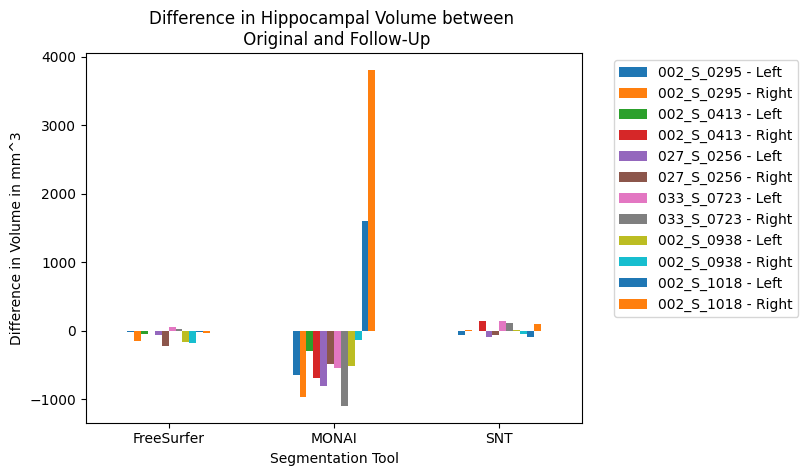

In [42]:
bar_plot_diff_vol(df_diff_orig_follow_all, ['FreeSurfer','MONAI', 'SNT'])

In [57]:
df_orig_follow_vols_snt = orig_follow_tool('SNT', df_original_data, df_follow_up_data)

In [45]:
#getting the dataframes for each tool to be visualized:
df_orig_follow_vols_snt = orig_follow_tool('SNT', df_original_data, df_follow_up_data)
df_orig_follow_vols_fs = orig_follow_tool('FreeSurfer', df_original_data, df_follow_up_data)
df_orig_follow_vols_monai = orig_follow_tool('MONAI', df_original_data, df_follow_up_data)

In [46]:
def plot_tool_ind_patient_progess(df_orig_follow_vols_list, tools):

  keys = df_orig_follow_vols_list[0].keys() #each list will contain the same keys just in a different order

  for j in range(0, len(keys), 2):

    legend_labels = []

    for i in range(len(df_orig_follow_vols_list)):
      current_vols_df = df_orig_follow_vols_list[i]
      plt.plot(['Original', 'Follow-up'], [current_vols_df[keys[j]][0], current_vols_df[keys[j]][1]])
      plt.plot(['Original', 'Follow-up'], [current_vols_df[keys[j+1]][0], current_vols_df[keys[j+1]][1]])
      
      legend_labels.append(keys[j] + " "+ tools[i])
      legend_labels.append(keys[j+1] + " "+ tools[i])
      patient_id = str(keys[j])      

    plt.legend(legend_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlabel('Time of Segmented Scan') 
    plt.ylabel('Hippocampal Volume in mm^3')
    plt.title("Predicition Progression for " + patient_id[:10])
    plt.show()



In [48]:
#making plots of each of the tools segmentation predicitions for the original and follow up scan:

def plot_tool_progression_pred(df_orig_follow_vols_list, tool):

  keys_list = df_orig_follow_vols_list[0].keys()
  

  for key in keys_list:

    for i in range(len(df_orig_follow_vols_list)):
      current_list = df_orig_follow_vols_list[i]
      current_list[key].plot()
      #plt.plot(['Original', 'Follow-up'], [current_list[key][0], current_list[key][1]])
      plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
      plt.xlabel('Time of Segmented Scan') 
      plt.ylabel('Hippocampal Volume in mm^3')
      plt.title(" Predicition Progression of " + tool)
  
  plt.show()

# Processing the Hippocampal Volumes of a Data Subset (Six Patients):

In [50]:
def bar_plot_orig_vols(df_diff_vols, tools):
  df_diff_vols.index = tools
  df_diff_vols.plot.bar()
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.xticks(rotation='horizontal')
  plt.xlabel('Segmentation Tool') 
  plt.ylabel('Hippocampal in Volume in mm^3')
  plt.title("Predicted Hippocampal Volume \n in Original Segmented Scan")
  plt.show()

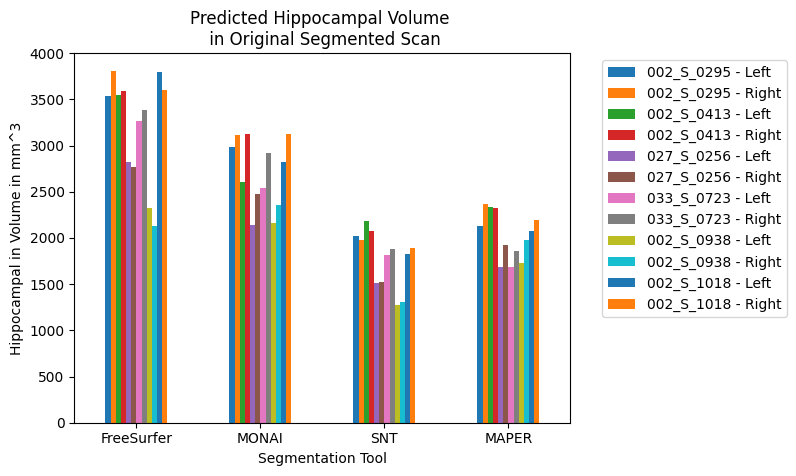

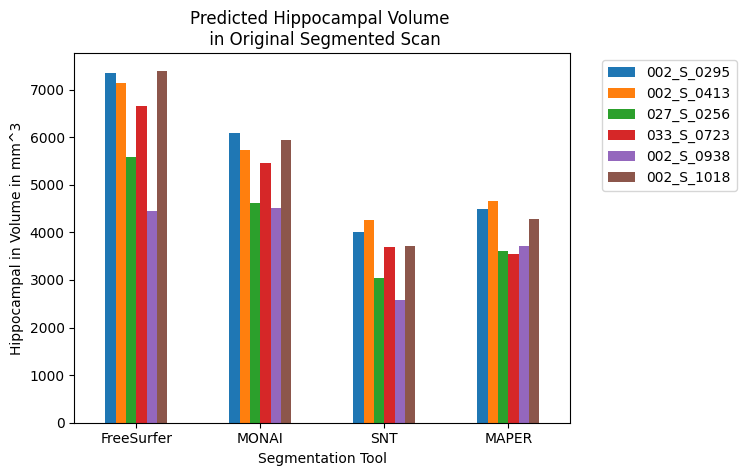

In [51]:
bar_plot_orig_vols(df_original_data, ['FreeSurfer', 'MONAI', 'SNT', 'MAPER'])
bar_plot_orig_vols(df_combined_original_data, ['FreeSurfer', 'MONAI', 'SNT', 'MAPER'])

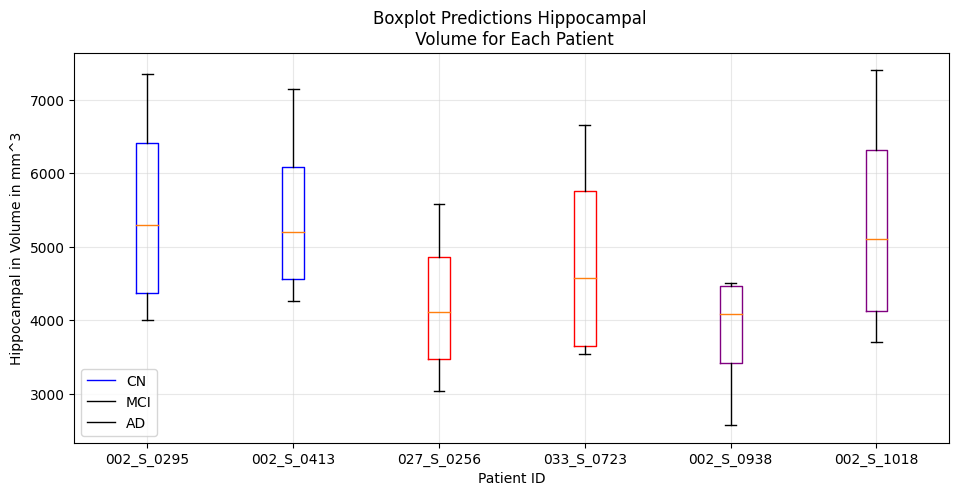

In [53]:
# boxplot style inspiration from https://matplotlib.org/2.0.2/examples/pylab_examples/boxplot_demo2.html
# and https://towardsdatascience.com/create-and-customize-boxplots-with-pythons-matplotlib-to-get-lots-of-insights-from-your-data-d561c9883643
# bx_plt = df_combined_original_data.boxplot()

fig, ax1 = plt.subplots(figsize=(10, 6))
#fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

b1 = ax1.boxplot(pd.DataFrame(df_combined_original_data.iloc[:,:2]), positions=[1,2], boxprops=dict(color='blue'))
b2 = ax1.boxplot(pd.DataFrame(df_combined_original_data.iloc[:,2:4]), positions=[3,4], boxprops=dict(color='red'))
b3 = ax1.boxplot(pd.DataFrame(df_combined_original_data.iloc[:,4:6]), positions=[5,6], boxprops=dict(color='purple'))


ax1.legend(['CN', 'MCI', 'AD'])
ax1.set_xticklabels(cols_combined_vol_patients)
plt.xlabel('Patient ID') 
plt.ylabel('Hippocampal in Volume in mm^3')
plt.title("Boxplot Predictions Hippocampal \n Volume for Each Patient")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)


In [54]:
#finding the maximum and minimum volume prediction in each column (corresponds to a single patient) to find out which patient has the highest spread in estimates 
def get_pred_range_patients(df_data):

  patients_order_list = list(df_data.columns)
  original_maxs_list = list(df_data.max(axis=0))
  original_mins_list = list(df_data.min(axis=0))

  absolute_range_list = []

  for i in range(len(patients_order_list)):
    spread = np.round(np.absolute(original_maxs_list[i] - original_mins_list[i]), 2)
    absolute_range_list.append(spread)

  return absolute_range_list, patients_order_list 


In [55]:
#finding the maximum and minimum volume prediction in each column (corresponds to a single patient) to find out which patient has the highest spread in estimates 
original_vol_range_list, patients_order_list = get_pred_range_patients(df_combined_original_data)
pd.DataFrame(original_vol_range_list, patients_order_list).T

,002_S_0295,002_S_0413,027_S_0256,033_S_0723,002_S_0938,002_S_1018
0,3346.71,2879.23,2549.69,3106.04,1933.28,3685.92


# Processing with Larger Dataset (Thirty Patients):

In [58]:
volumes_all_original_dicts_list,  tools_list_all_original = compute_dict_volumes(data_all_original_dict)
combined_all_volumes_original_dicts_list,  tools_all_list_original = compute_dict_volumes(data_all_original_dict, separate=False)
patient_ids_all_original = list(combined_all_volumes_original_dicts_list[0].keys())

In [62]:
df_combined_all_original_data = df_hippo_vol_dict(data_all_original_dict, patient_ids_all_original , separate=False)
df_combined_all_original_data.head()

,002_S_0295,002_S_0413,027_S_0256,033_S_0723,002_S_0938,002_S_1018,002_S_0685,003_S_0907,005_S_0222,005_S_0610,...,031_S_0294,035_S_0048,035_S_0156,057_S_0474,073_S_0089,128_S_0135,130_S_1290,002_S_0619,002_S_0729,003_S_0981
FreeSurfer,7346.00,7140.00,5584.00,6655.00,4453.00,7396.00,7409.00,6915.00,5533.00,6028.00,...,6001.00,7570.00,7868.00,5122.00,8094.00,7209.00,6107.00,5788.00,6308.00,6710.00
SNT,3999.29,4260.77,3034.31,3692.45,2578.72,3710.08,4836.97,4310.75,3244.98,3863.27,...,4191.82,4331.22,5108.98,3404.52,4637.77,4103.42,3122.86,3334.69,2923.56,3789.01
MAPER,4494.09,4657.79,3616.50,3548.96,3708.45,4270.74,4987.52,4295.76,4227.34,4181.32,...,4553.81,4021.32,4855.58,4814.96,4239.22,4196.33,3564.99,4889.70,3894.14,3648.40


## Comparing Hippocampal Volume Predictions with Patients' Disease Diagnosis:

In [66]:
#importing a spreadsheet holding the associated disease stage diagnosis CN, MCI and AD for each patient id so that it can be used easily 
diagnosis_ids = pd.read_csv('id_and_diagnosis.csv', sep=',')

#formatting the diagnosis dataframe to match the one holding the individual volume predictions to be able to combine them
diagnosis_ids_formatted = diagnosis_ids.T
diagnosis_ids_formatted.columns = diagnosis_ids_formatted.iloc[0]
diagnosis_ids_formatted = diagnosis_ids_formatted.tail(-1)
diagnosis_ids_formatted_list = list(diagnosis_ids_formatted.columns)
df_combined_all_original_data_formatted = df_combined_all_original_data.reindex(columns=diagnosis_ids_formatted_list)

In [65]:
#combine data frame with diagnosis and with volume by patient id
df_combined_all_original_diagnosis = pd.concat([df_combined_all_original_data_formatted,diagnosis_ids_formatted])
df_combined_all_original_diagnosis 

,002_S_0685,003_S_0981,003_S_0907,005_S_0610,007_S_1222,035_S_0156,035_S_0048,073_S_0089,002_S_0413,002_S_0295,...,130_S_1290,057_S_0474,027_S_1081,024_S_1171,020_S_0213,013_S_1205,005_S_0814,002_S_0619,002_S_1018,002_S_0938
FreeSurfer,7409.0,6710.0,6915.0,6028.0,7363.0,7868.0,7570.0,8094.0,7140.0,7346.0,...,6107.0,5122.0,5466.0,7877.0,7750.0,5452.0,4808.0,5788.0,7396.0,4453.0
SNT,4836.97,3789.01,4310.75,3863.27,3856.76,5108.98,4331.22,4637.77,4260.77,3999.29,...,3122.86,3404.52,3230.55,4764.93,4733.96,2797.65,2558.37,3334.69,3710.08,2578.72
MAPER,4987.52,3648.4,4295.76,4181.32,3922.11,4855.58,4021.32,4239.22,4657.79,4494.09,...,3564.99,4814.96,4445.75,5311.1,4780.68,3317.88,3664.76,4889.7,4270.74,3708.45
Diagnosis,CN,CN,CN,CN,CN,CN,CN,CN,CN,CN,...,AD,AD,AD,AD,AD,AD,AD,AD,AD,AD
Sex,F,F,F,M,F,M,M,M,F,M,...,F,F,M,M,M,M,F,M,F,F


In [67]:
#df_combined_all_original_diagnosis.to_csv('hippocampal_volume_all_with_diagnosis.csv')

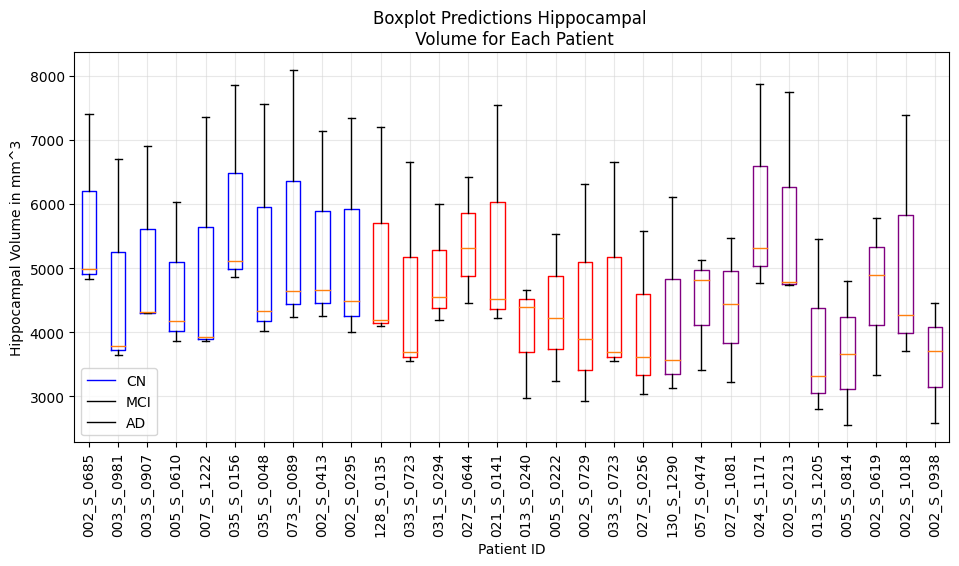

In [68]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


b1 = ax1.boxplot(df_combined_all_original_diagnosis.iloc[:3, :10], positions=[1,2,3,4,5,6,7,8,9,10], boxprops=dict(color='blue'))
b2 = ax1.boxplot(df_combined_all_original_diagnosis.iloc[:3, 10:20], positions=[11,12,13,14,15,16,17,18,19,20], boxprops=dict(color='red'))
b3 = ax1.boxplot(df_combined_all_original_diagnosis.iloc[:3, 20:30], positions=[21,22,23,24,25,26,27,28,29,30], boxprops=dict(color='purple'))


ax1.legend(['CN', 'MCI', 'AD'])
ax1.set_xticklabels(diagnosis_ids_formatted.columns, rotation= 'vertical')
plt.xlabel('Patient ID') 
plt.ylabel('Hippocampal Volume in mm^3')
plt.title("Boxplot Predictions Hippocampal \n Volume for Each Patient")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)

In [69]:
# colorcoding the x_ticks which represent the different patient ids depending on the diagnosis of the patient -> there are three different diagnosis and 10 patients of each type (previously ordered)
colors = ['blue', 'red', 'purple']
tick_colors_list = []

for i in range(len(colors)):
  for j in range(10):
    tick_colors_list.append(colors[i])

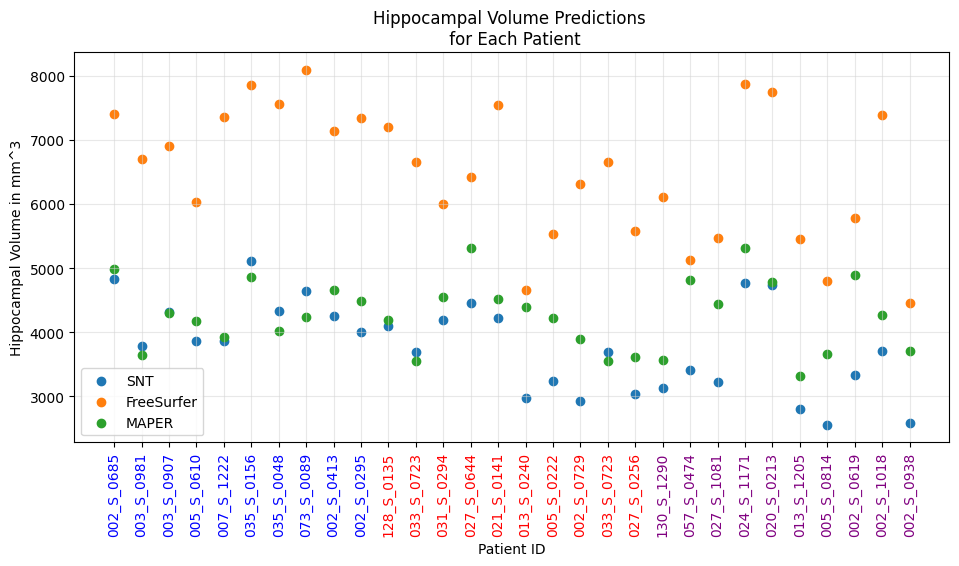

In [70]:
# scatter the predictions of each tool  

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)

scatter1 = ax1.scatter(np.arange(1, 31), df_combined_all_original_diagnosis.iloc[1]) #SNT
scatter2 = ax1.scatter(np.arange(1, 31), df_combined_all_original_diagnosis.iloc[0]) #FreeSurfer
scatter3 = ax1.scatter(np.arange(1, 31), df_combined_all_original_diagnosis.iloc[2]) # MAPER

ax1.legend(['SNT', 'FreeSurfer', 'MAPER'])
plt.xlabel('Patient ID') 
plt.ylabel('Hippocampal Volume in mm^3')
plt.title("Hippocampal Volume Predictions \n for Each Patient")

plt.xticks(np.arange(1,31), df_combined_all_original_diagnosis.columns ) 
ax1.set_xticklabels(df_combined_all_original_diagnosis.columns, rotation= 'vertical')

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors_list):
   ticklabel.set_color(tickcolor)



In [71]:
#Code for finding the best fit line found at: https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python

def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return a, b

In [72]:
def SNT_comparison_plot(diff_dataframe, columns, tool, tick_colors_list):

  fig, ax1 = plt.subplots(figsize=(10, 6))
  bar1 = ax1.bar(np.arange(1, (len(columns)+1)), diff_dataframe) 

  #plotting the found best fit line through the bar plot:
  c, m = best_fit(np.arange(1, (len(columns)+1)), diff_dataframe) #finding the best fit line -> mx+b

  yfit = [c + m * xi for xi in np.arange(1,(len(columns)+1))] #m represents the gradient of the linear best fit line
  plt.plot(np.arange(1,(len(columns)+1)), yfit, 'r')
  
  #formatting the plot:
  plt.xticks(np.arange(1,(len(columns)+1)), columns) 
  ax1.set_xticklabels(columns, rotation= 'vertical')

  for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors_list):
    ticklabel.set_color(tickcolor)

  best_fit_label =  "Best Fit: {m_var:.2f}x + {c_var:.2f}".format(m_var = m, c_var = c)

  ax1.yaxis.grid(True, linestyle='-', color='lightgrey', alpha=0.5)
  ax1.xaxis.grid(True, linestyle='-', color='lightgrey', alpha=0.5)
  ax1.legend([best_fit_label, '|SNT - {tool_var}|'.format(tool_var=tool)], loc= 'upper left')
  plt.xlabel('Disease Stage') 
  plt.ylabel('Absolute Difference in Hippocampal \n Volume in mm^3')
  plt.title("Difference in Hippocampal Volume Predictions \n between SNT and {tool_var}".format(tool_var = tool))

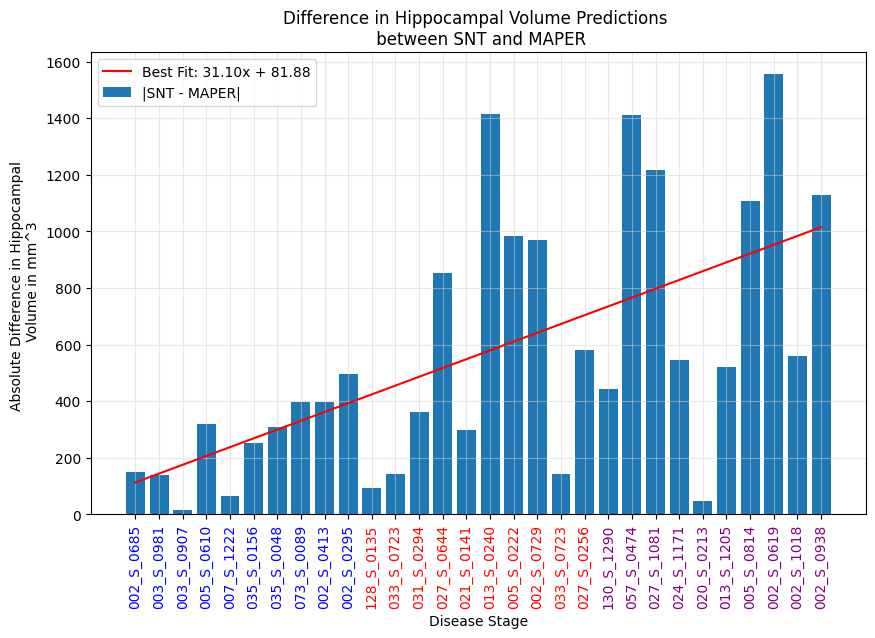

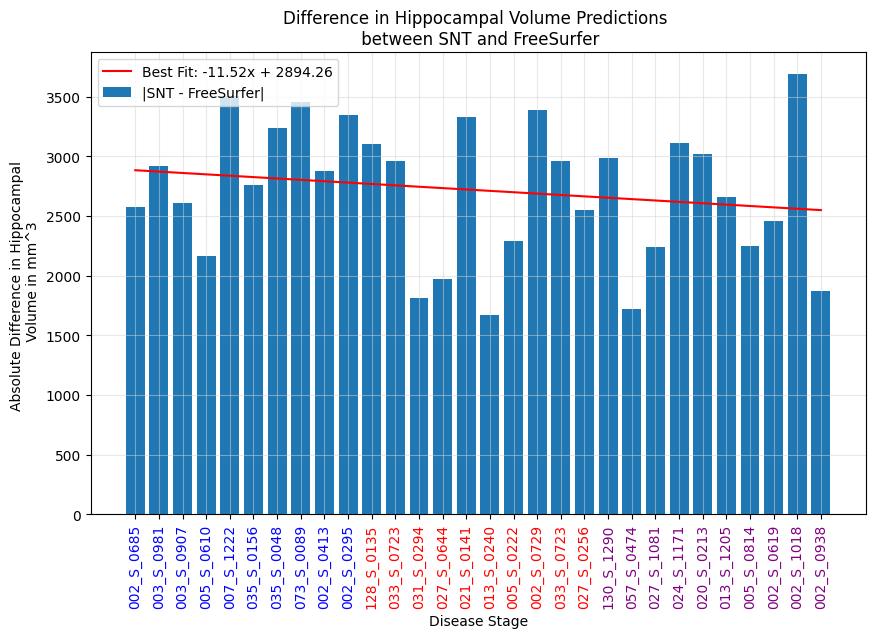

In [73]:
#Finding the absolute difference between the hippocampal volumes by subtracting the rows of the corresponding tools in the dataframe for each patient
absolute_diff_SNT_MAPER = np.absolute(df_combined_all_original_diagnosis.loc['SNT'] - df_combined_all_original_diagnosis.loc['MAPER'])
SNT_comparison_plot(absolute_diff_SNT_MAPER, df_combined_all_original_diagnosis.columns, 'MAPER', tick_colors_list)

absolute_diff_SNT_FS = np.absolute(df_combined_all_original_diagnosis.loc['SNT'] - df_combined_all_original_diagnosis.loc['FreeSurfer'])
SNT_comparison_plot(absolute_diff_SNT_FS, df_combined_all_original_diagnosis.columns, 'FreeSurfer', tick_colors_list)

#Make Boxplot over the Diagnosis Groups

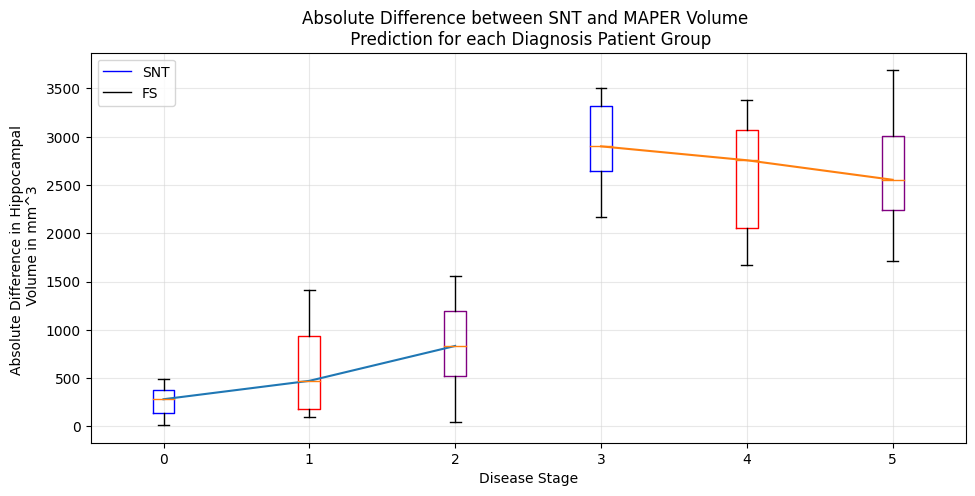

In [74]:
# PLOT FOR SNT AND MAPER COMPARISON
# the list is ordered by the diagnosis labels (CN, MCI, AD) so the first ten elements belong to the CN label and so on:

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

b1 = ax1.boxplot(absolute_diff_SNT_MAPER[:10], positions=[0], boxprops=dict(color='blue'))
median_val1 = b1['medians'][0].get_ydata()

b2 = ax1.boxplot(absolute_diff_SNT_MAPER[10:20], positions=[1], boxprops=dict(color='red'))
median_val2 = b2['medians'][0].get_ydata()

b3 = ax1.boxplot(absolute_diff_SNT_MAPER[20:30], positions=[2], boxprops=dict(color='purple'))
median_val3 = b3['medians'][0].get_ydata()

b4 = ax1.boxplot(absolute_diff_SNT_FS[:10], positions=[3], boxprops=dict(color='blue'))
median_val4 = b4['medians'][0].get_ydata()

b5 = ax1.boxplot(absolute_diff_SNT_FS[10:20], positions=[4], boxprops=dict(color='red'))
median_val5 = b5['medians'][0].get_ydata()

b6 = ax1.boxplot(absolute_diff_SNT_FS[20:30], positions=[5], boxprops=dict(color='purple'))
median_val6 = b6['medians'][0].get_ydata()

ax1.plot([0,1,2], [median_val1[1], median_val2[1], median_val3[1]])
ax1.plot([3,4,5], [median_val4[1], median_val5[1], median_val6[1]])

#ax1.set_xticklabels(['CN', 'MCI', 'AD'])
plt.xlabel('Disease Stage') 
plt.legend(['SNT', 'FS'])
plt.ylabel('Absolute Difference in Hippocampal \n Volume in mm^3')
plt.title("Absolute Difference between SNT and MAPER Volume \n Prediction for each Diagnosis Patient Group")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)

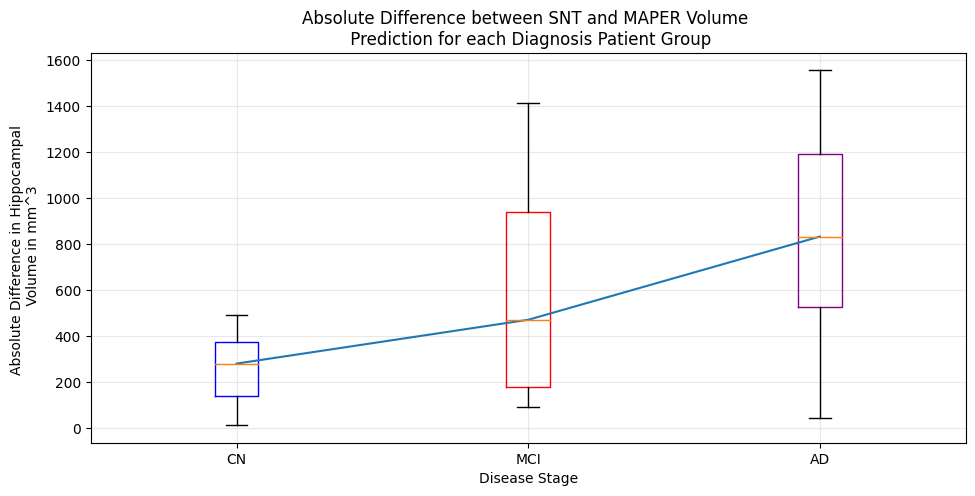

In [76]:
# PLOT FOR SNT AND MAPER COMPARISON
# the list is ordered by the diagnosis labels (CN, MCI, AD) so the first ten elements belong to the CN label and so on:

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

b1 = ax1.boxplot(absolute_diff_SNT_MAPER[:10], positions=[0], boxprops=dict(color='blue'))
median_val1 = b1['medians'][0].get_ydata()

b2 = ax1.boxplot(absolute_diff_SNT_MAPER[10:20], positions=[1], boxprops=dict(color='red'))
median_val2 = b2['medians'][0].get_ydata()

b3 = ax1.boxplot(absolute_diff_SNT_MAPER[20:30], positions=[2], boxprops=dict(color='purple'))
median_val3 = b3['medians'][0].get_ydata()

ax1.plot([0,1,2], [median_val1[1], median_val2[1], median_val3[1]])

ax1.set_xticklabels(['CN', 'MCI', 'AD'])
plt.xlabel('Disease Stage') 
plt.ylabel('Absolute Difference in Hippocampal \n Volume in mm^3')
plt.title("Absolute Difference between SNT and MAPER Volume \n Prediction for each Diagnosis Patient Group")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)


End of Notebook.